# Homework 2 - 2305

* Tommaso Bertola 2086990
* Giacomo Di Prima 2086992
* Giuseppe Viterbo 2086516
* Marzo Zenari 2097012

In [1]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import itertools

plt.rcParams['font.size'] = 14

# Training  
In the training part we define the python class `boltzmanmachine`, the data selection, and the network parameters.The boltzman machine has been trained with amplitudes that range from 0.05 to 0.5. The weights and bias obtained by the training algorithm are stored in `.npz` files to easily access them in the fantasy particles generation algorithm. As a consistency check we introduced the calculation of the LogLikelihood function.

## Boltzmann machine class 

In [2]:
class boltzmanmachine:
    
    def __init__(self, L, M, sigma, De=2, vmin=-1, spin=True):
        '''
        Initialize the object with defaults parameter which are determined by
        meta reciew.
        w: network weights
        a: visible bias
        b: hidden bias
        spin: set the notation used by the model, (0,1) or (-1,1)
        DE: energy separation among the two possible states allowed in the positive phases, 1 or 2
        vmin: minimum value of the representation
        '''
        self.w = np.random.normal(loc=0.0, scale=sigma, size=(L,M))
        self.a = np.random.normal(loc=0.0, scale=sigma, size=L)
        self.b = b = np.zeros(M)
        self.h = np.zeros(M)

        self.spin=spin
        
        self.DE = De
        self.L = int(L)
        self.M = int(M)
        self.vmin=vmin
        
        self.v_data, self.v_model = None, None
        self.h_data, self.h_model = None, None
        self.vh_data,self.vh_model= None, None
        
        #one hot encoding of the four possible states
        if self.spin:
            self.csi1 = np.array([1,-1,-1,-1])    
            self.csi2 = np.array([-1,1,-1,-1])   
            self.csi3 = np.array([-1,-1,1,-1])    
            self.csi4 = np.array([-1,-1,-1,1])  
        else:
            self.csi1 = np.array([1,0,0,0])    
            self.csi2 = np.array([0,1,0,0])   
            self.csi3 = np.array([0,0,1,0])    
            self.csi4 = np.array([0,0,0,1]) 
            
        self.csi = [self.csi1, self.csi2, self.csi3, self.csi4]
        
        #algotithm variables
        self.sa_t0 = 0
        self.sb_t0 = 0
        self.sw_t0 = 0
        
        self.ma_t0 = 0
        self.mb_t0 = 0
        self.mw_t0 = 0
        
        self.batch_counter = 0
        
    def load_model(self, file_name):
        model = np.load(file_name)
        
        self.w = model['w']
        self.a = model['a']
        self.b = model['b']
        
        
        
    def save_model(self, file_name):
        np.savez(file_name, a=self.a, b=self.b, w=self.w)
        
        
        
    def init_avg(self):
        '''
        Set  to zero the averages quantities needed to compute the gradien
        '''
        self.v_data, self.v_model = np.zeros(self.L),np.zeros(self.L)
        self.h_data, self.h_model = np.zeros(self.M),np.zeros(self.M)
        self.vh_data,self.vh_model= np.zeros((self.L,self.M)),np.zeros((self.L,self.M))
        
        
        
    def positive(self, v_in, Amp=1.):
        '''
        Positive phase of the training
        Visible -> Hidden
        No one-hot encoding needed
        '''
        act = np.dot(v_in, self.w) + self.b      
        #print(act)
        argument=np.exp(-Amp*self.DE*act)
        prob = 1. / (1. + argument)
        n = np.shape(act)
        h = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        h[np.random.random_sample(n) < prob] = 1
        
        return h
    
    def negative(self, h_in, Amp=1.):
        '''
        Negative phase of the training
        Hidden -> Visible
        With ne-hot encoding needed
        '''
        
        weigths = np.reshape(np.dot(h_in, self.w.T) + self.a, (5,4) ) 

        
        E1 = np.dot(weigths, self.csi1) #array of length 5, the number of amminoacids
        E2 = np.dot(weigths, self.csi2)
        E3 = np.dot(weigths, self.csi3)
        E4 = np.dot(weigths, self.csi4)
        


        Z = np.exp(-Amp*E1) + np.exp(-Amp*E2) + np.exp(-Amp*E3) + np.exp(-Amp*E4) #partition function for each amminoacid
        
        p1 = np.exp(-Amp*E1)/Z 
        p2 = np.exp(-Amp*E2)/Z
        p3 = np.exp(-Amp*E3)/Z
        p4 = np.exp(-Amp*E4)/Z
        
        
        
        p = np.reshape(np.concatenate((p1, p2, p3, p4)), (4, 5))      

        
        cum = np.cumsum(p, axis=0) #(4x5) containing the comulatives  
        r = np.random.random(size=5)        
        
        mask = cum < r    
        indx = []    
        
        for i in range(mask.shape[1]):
            __, index = np.unique(mask[:, i], return_index=True)
            indx.append(index[0])
            
        vf=np.concatenate((self.csi[indx[0]], self.csi[indx[1]], self.csi[indx[2]], self.csi[indx[3]], self.csi[indx[4]]))
        return vf
        
    
    def update_vh(self, v_k, vf, h, hf, mini):
        '''
        Update the averages needed to compute the gradient
        '''
        self.v_data  += v_k/mini
        self.v_model += vf/mini
        self.h_data  += h/mini
        self.h_model += hf/mini
        self.vh_data += np.outer(v_k.T,h)/mini
        self.vh_model+= np.outer(vf.T,hf)/mini
    
    def SGD(self, l_rate_m):
        '''
        Stochastic gradient descent algorithm
        '''
        dw = l_rate_m*(self.vh_data - self.vh_model)
        da = l_rate_m*(self.v_data - self.v_model)
        db = l_rate_m*(self.h_data - self.h_model)
        
        self.w += dw
        self.a += da
        self.b += db
        
    def RMSprop(self, eta_t, beta=0.9, epsilon=1e-8):
        '''
        RMSprop algorithm
        '''
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model
        
        sa_t = beta*self.sa_t0 + (1-beta)*ga_t**2
        sb_t = beta*self.sb_t0 + (1-beta)*gb_t**2
        sw_t = beta*self.sw_t0 + (1-beta)*gw_t**2
        
        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t
        
        
        self.a = self.a + eta_t*ga_t/np.sqrt(sa_t + epsilon)
        self.b = self.b + eta_t*gb_t/np.sqrt(sb_t + epsilon)
        self.w = self.w + eta_t*gw_t/np.sqrt(sw_t + epsilon)
        
        
    def ADAM(self, eta_t, epoch, beta1=0.9, beta2=0.99,epsilon=1e-8):
        '''
        ADAM algorithm
        '''
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model

        ma_t = beta1*self.ma_t0 + (1-beta1)*ga_t
        mb_t = beta1*self.mb_t0 + (1-beta1)*gb_t
        mw_t = beta1*self.mw_t0 + (1-beta1)*gw_t

        sa_t = beta2*self.sa_t0 + (1-beta2)*ga_t**2
        sb_t = beta2*self.sb_t0 + (1-beta2)*gb_t**2
        sw_t = beta2*self.sw_t0 + (1-beta2)*gw_t**2

        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t

        self.ma_t0 = ma_t
        self.mb_t0 = mb_t
        self.mw_t0 = mw_t

        ma_t_hat = ma_t/(1-beta1**epoch) 
        mb_t_hat = mb_t/(1-beta1**epoch) 
        mw_t_hat = mw_t/(1-beta1**epoch)

        sa_t_hat = sa_t/(1-beta2**epoch) 
        sb_t_hat = sb_t/(1-beta2**epoch) 
        sw_t_hat = sw_t/(1-beta2**epoch)

        self.a = self.a + eta_t*ma_t_hat/(np.sqrt(sa_t_hat) + epsilon)
        self.b = self.b + eta_t*mb_t_hat/(np.sqrt(sb_t_hat) + epsilon)
        self.w = self.w + eta_t*mw_t_hat/(np.sqrt(sw_t_hat) + epsilon)
        
    def train(self, data, learning_rate, batch_size, n_contrastive_div, Amp_training, Algorithm, epoch=1):
        
        '''
        Using the methods of the class to train the RBM. We also implement the Contrastive Divergence algorithm
        
        '''
        
        if self.batch_counter == 0:
            self.init_avg()
            
        v_k = np.copy(data)
        vf = np.copy(data)
        
        for i in np.arange(n_contrastive_div):
            h = self.positive(vf, Amp_training)
            vf = self.negative(h, Amp_training)
        hf = self.positive(vf, Amp_training)
        self.h = np.copy(h)
        
        self.update_vh(v_k, vf, h, hf, batch_size)
        
        self.batch_counter += 1
        
        if self.batch_counter == batch_size:
            if Algorithm == 'SGD':
                self.SGD(learning_rate)
            if Algorithm == 'RMSprop':
                self.RMSprop(learning_rate)
            if Algorithm == 'Adam':
                self.ADAM(l_rate, epoch+1)
     
            self.batch_counter = 0

    def gen_fantasy(self, data, Amp_gen):
        '''
        Generate fantasy particles using the positive and negative phase.
    
        '''
        vf = np.zeros_like(data)
        N = data.shape[0]
        
        for k in range(N):
            # positive CD phase: generating h 
            h = self.positive(data[k],Amp_gen)
            # negative CD phase: generating fantasy vf with low T == large GAP
            vf[k] = self.negative(h,Amp_gen)
            
        return vf


## Data selection

In [3]:
dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
v = np.loadtxt(fname, delimiter=" ",dtype=int)
v0 = np.copy(v)  #Copy original data to analyse later

## Network parameters

In [4]:
N = len(v)       #Number of rows
L = len(v[0])    #Set the number of visible variable
M = 3            #Set the number of hidden units

sigma = np.sqrt(4. / float(L + M))

print(f'Each of N={N} data has L={L} digits')
print(f'The network has {L} visible units and {M} hidden units')
print(f'Initializing std {sigma}')

Each of N=10000 data has L=20 digits
The network has 20 visible units and 3 hidden units
Initializing std 0.41702882811414954


## Defining training parameters

In [5]:
seed = 1                  # set the random seed in order to reproduce results 
cdn  = 1                  # set the number of contrastive divergence iteration

n_epochs = 100            # set the number of epochs

spin = True               # chose the kind of representation, if True -> [-1,1], else -> [0,1]

if spin:
    GAP=2                 # sigmoid takes into account energy difference = 2 if spin = True
    v = 2*v - 1           # convert [0,1] -> [-1,1]
    vmin=-1
else:
    GAP=1
    vmin=0
    
Algorithm = 'RMSprop'    # Choosing the optimization algorithm for Gradient Descent

amp_list = [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # Choosing the amplitude

## LogLikelihood
Defining the Energy function and the Partition function to easily compute the Loglikelihood.

In [6]:
def E(v, h, w, a, b):
    return -(np.dot(v, np.dot(w, h))+np.dot(a,v)+np.dot(b,h))

def Z(possible_v, possible_h, w, a, b, amp):
    z=0
    for v_i in possible_v:
        for h_j in possible_h:
            z+=np.exp(E(v_i, h_j, w, a, b)*GAP*amp)
    return z

Calculation of all the possible states needed for the computation of the Partition function

In [7]:
v_data = v

# parameters of the data
n_encodings = 4
n_ammino = 5
n_h = M
n_h_val = 2

#lists all possible combinations of proteins
possibilities_v=list(itertools.product(['1000','0100','0010','0001'], repeat=n_ammino))
possibilities_h=list(itertools.product(['1','0'], repeat=n_h))

#lists containing all the possible combination of the proteins
possible_v=np.zeros((n_encodings**n_ammino, n_encodings*n_ammino))
possible_h=np.zeros((n_h_val**n_h, n_h))

#converts proteins to decimal representation and convertion to spin representation if spin = True
for i,v_i in enumerate(possibilities_v):
    possible_v[i]=np.array([int(i) for i in ''.join(v_i)])
    
if spin:
    possible_v = 2*possible_v -1

for i,h_i in enumerate(possibilities_h):
    possible_h[i]=np.array([int(i) for i in ''.join(h_i)])
    
if spin:
    possible_h = 2*possible_h -1

## Model Training
In this part we train the model and compute the Loglikelihood value at every epoch and we plot the weights obtained by the training algorithm every ten epochs. Both the configuration {0,1} and {-1,1} are trained, but in this notebook only the {-1,1} training is shown.

0.05 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

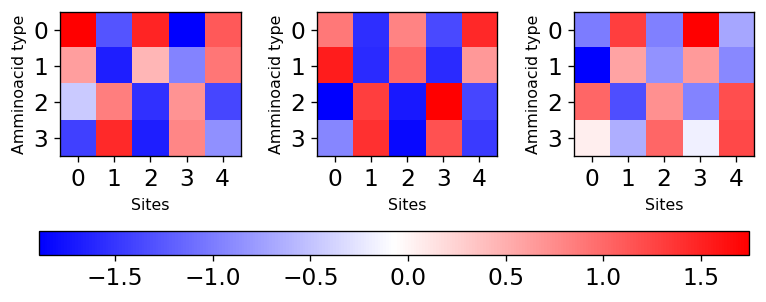

99 	 ...Done!
0.1 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

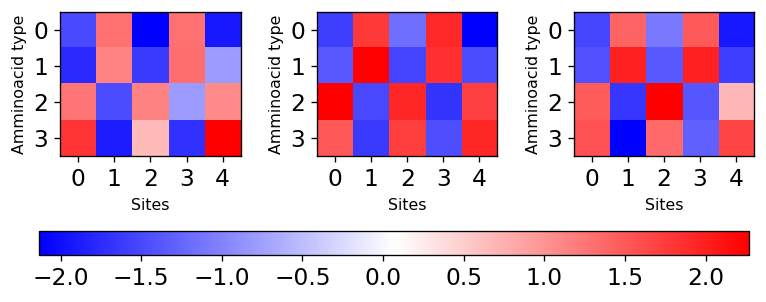

99 	 ...Done!
0.15 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

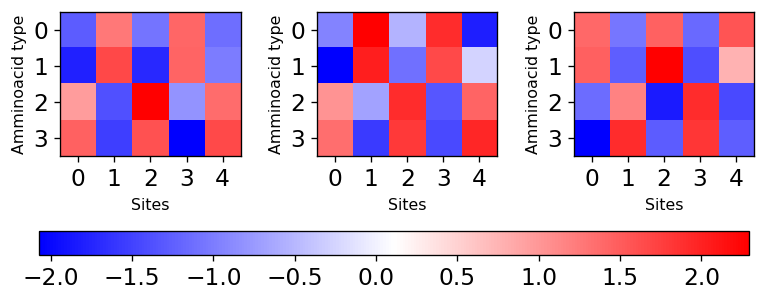

99 	 ...Done!
0.2 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

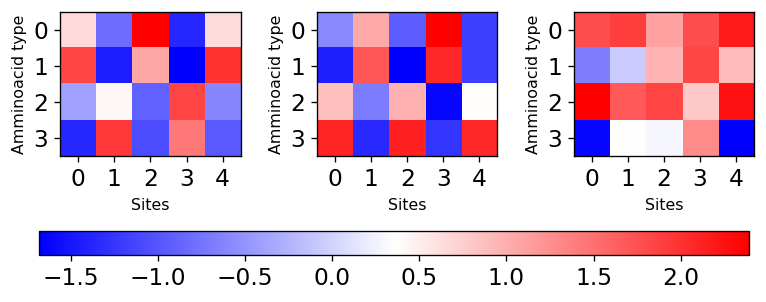

99 	 ...Done!
0.25 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

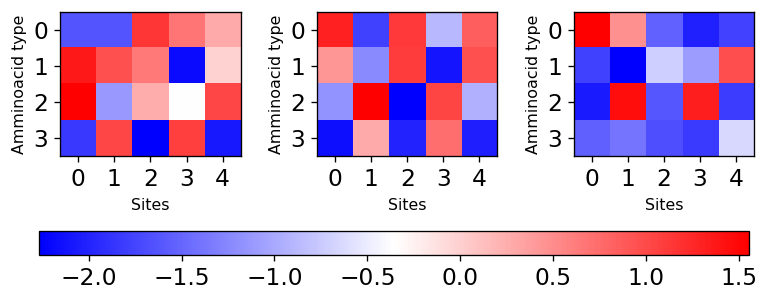

99 	 ...Done!
0.3 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

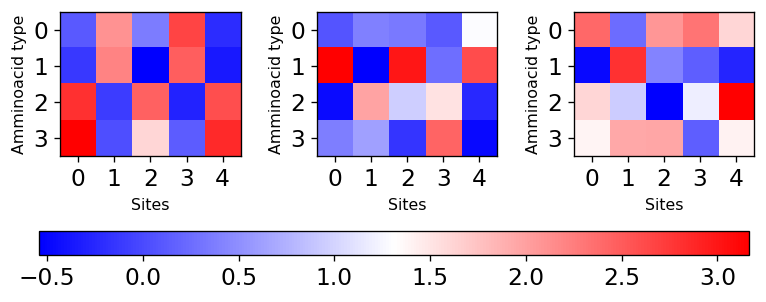

99 	 ...Done!
0.35 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

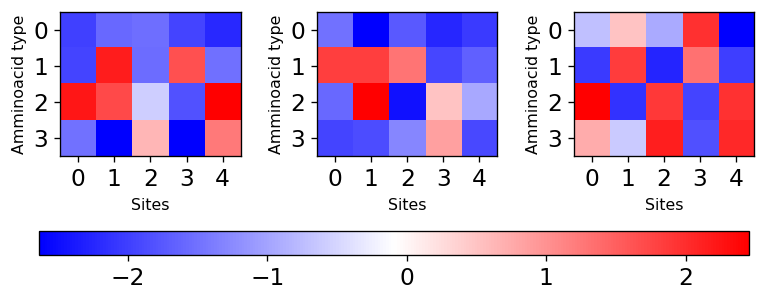

99 	 ...Done!
0.4 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

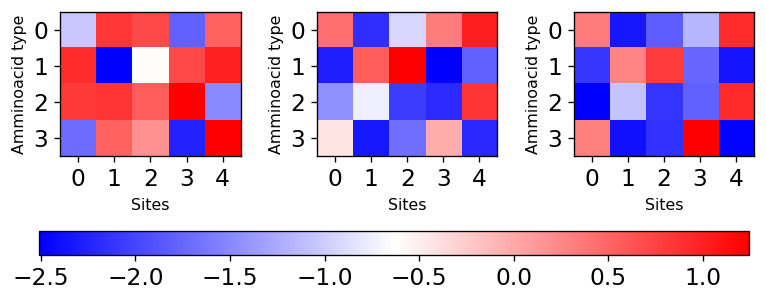

99 	 ...Done!
0.45 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

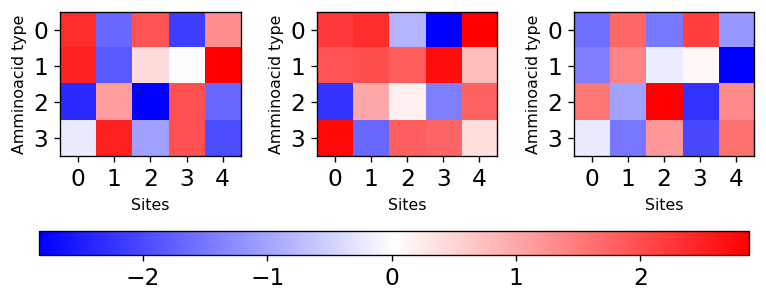

99 	 ...Done!
0.5 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

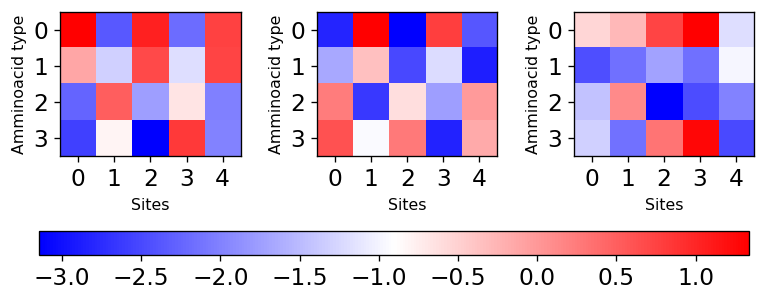

99 	 ...Done!


In [9]:
# random seed for reproducibility
np.random.seed(seed)

# learning rate
l_rate = 1e-3

# minibatch
mini_batch = 500

#Loglikelihood
Loglikelihood_calculation = True
Loglikelihood = np.zeros((len(amp_list), n_epochs))

# train model for different amplitudes in amp_list
print('===================================================')
for i, amp in enumerate(amp_list):
 
    #RBM initialization
    rbm = boltzmanmachine(L,M,sigma,vmin=vmin, spin=spin)
    print(amp, end=' ')
    
    #numpy vectors for the computation of the Loglikelihood
    Loglikelihood = np.zeros(n_epochs)
    E_list = np.zeros(n_epochs)
    Z_list = np.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        for k in range(N):
            rbm.train(data=v[k],
                      learning_rate=l_rate,
                      batch_size=mini_batch,
                      n_contrastive_div=cdn,
                      Amp_training=amp,
                      Algorithm=Algorithm)

        #Loglikelihood calculation
        if Loglikelihood_calculation==True:
            
            #positive phase at the end of the epoch used for evaluation of the Energy
            h_loglikelihood = np.zeros((N,M))
            for j in range(N):
                h_loglikelihood[j] = rbm.positive(v_data[j], Amp=amp)
                
            E_var = 0
            for i, h_i in enumerate(h_loglikelihood):
                E_var += E(v_data[i], h_i, rbm.w, rbm.a, rbm.b)*GAP*amp
            mean_E = E_var/N
            Z_var = Z(possible_v, possible_h, rbm.w, rbm.a, rbm.b, amp)
            Loglikelihood[epoch] = - mean_E - np.log(Z_var) 
        

        # randomize the order of input data
        np.random.shuffle(v)
        
        #plot the weights for each hidden units
        if epoch==n_epochs-1: 
            
            #save Loglikelihood in a file 
            np.savez('Models/Loglikelihood/Loglikelihood'+'_'+str(amp).replace('.','')+'.npz', Loglikelihood=Loglikelihood)
            
            fig, ax = plt.subplots(nrows=1, ncols=M, figsize=(8,4), dpi=120)
            fig.tight_layout()
            
            ww = rbm.w.reshape((5,4,M))
            for h in range(M):
                c=ax[h].matshow(ww[:,:,h].T, cmap='bwr')
                ax[h].set_xlabel('Sites', fontsize=9.5)
                ax[h].set_ylabel('Amminoacid type', fontsize=9.5)
                ax[h].tick_params(top=False, bottom=True,
                       labeltop=False, labelbottom=True)

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.055, 0.17, 0.74, 0.05])
            fig.colorbar(c, cax=cbar_ax, orientation='horizontal')
            plt.show()
        print(epoch, end='')
    
    #save the parameters of the RBM obtained from the training 
    if spin:
        file_name='Models/'+str(Algorithm)+'_'+str(amp).replace('.','')+'_'+str(cdn)+'_spin'+'.npz'
    else:
        file_name='Models/'+str(Algorithm)+'_'+str(amp).replace('.','')+'_'+str(cdn)+'.npz'
    rbm.save_model(file_name)

    print(' \t ...Done!')
    

# Analysis 
In this part, we generate the fantasy particles using generation amplitudes that range from 0.05 to 0.5. In order to evaluate the perfomance of our Boltzman machine trained at different temperatures we introduce the Jensesn-Shannon (JS) divergence as a metric. We plot the heatmaps of the JS divergence in order to chose the best combiantion of amplitudes.

### Create a list with the file names containing the trained models

In [7]:
if spin:

    models = ['Models/RMSprop_005_1_spin.npz',
                  'Models/RMSprop_01_1_spin.npz',
                  'Models/RMSprop_015_1_spin.npz',
                  'Models/RMSprop_02_1_spin.npz',
                  'Models/RMSprop_025_1_spin.npz',
                  'Models/RMSprop_03_1_spin.npz',
                  'Models/RMSprop_035_1_spin.npz',
                  'Models/RMSprop_04_1_spin.npz',
                  'Models/RMSprop_045_1_spin.npz',
                  'Models/RMSprop_05_1_spin.npz']
    vmin= -1

else:
    models = ['Models/RMSprop_005_1.npz',
                  'Models/RMSprop_01_1.npz',
                  'Models/RMSprop_015_1.npz',
                  'Models/RMSprop_02_1.npz',
                  'Models/RMSprop_025_1.npz',
                  'Models/RMSprop_03_1.npz',
                  'Models/RMSprop_035_1.npz',
                  'Models/RMSprop_04_1.npz',
                  'Models/RMSprop_045_1.npz',
                  'Models/RMSprop_05_1.npz']
    vmin=0

## PDF 
Probability distribution function of the possible proteins obtanable from the one-hot encoding representation of the 5 amminoacids.  

In [8]:
def convert_to_decimal_protein(v):
    '''
    Convert the raw protein list of strings of 1s and 0s 
    to binary numbers
    '''
    protein_list = np.copy(v).astype(str)
    proteins_dataset = np.zeros(protein_list.shape[0]).astype(int)

    for k in np.arange(protein_list.shape[0]):
        proteins_dataset[k] = int(''.join(protein_list[k]),2)
        
    return list(proteins_dataset)

def return_protein_probabilities(decimal_proteins_list, n_amminoacids=5):
    '''
    Returns a pdf. Each element of the returned vector
    represents the probability of each one of the 4^5 proteins
    in the list passed to the function.
    
    The output vector length is always 4^5=1024, independently of
    the input proteins list passed as input.
    '''
    #number of amminoacids in the protein
    n_ammino=n_amminoacids
    
    #total number of preteins, to normalize the pdf
    n_proteins=len(decimal_proteins_list)

    #encoding of amminoacids
    v1,v2,v3,v4=np.eye(4)

    #list all possible combinations of proteins
    possibilities=list(itertools.product(['1000','0100','0010','0001'],
                                         repeat=n_ammino))

    #converts proteins to decimal representation
    decimal=list()
    for p in possibilities:
        decimal.append(int(''.join(p),2))

    #sort the representation from bigger to smaller values
    decimal.sort(reverse=True)

    #initialize a dict with proteins as keys
    protein_cnt=dict.fromkeys(decimal,0)

    #counts the number of times the protein was found
    for protein in decimal_proteins_list:
        protein_cnt[protein]+=1 

    #return the ordered list of 
    #normalized probabilities for each possible protein
    norm_prob=np.array(list(protein_cnt.values()))/n_proteins
    
    return norm_prob


## Computing the empirical probability distribution of our data

In [9]:
proteins_dataset0=convert_to_decimal_protein(v0)
Q=return_protein_probabilities(proteins_dataset0)

print('Len protein dataset: ',len(proteins_dataset0))
print('Len p_dataset: ', len(Q))
print('Norm p_dataset: ', Q.sum())

Len protein dataset:  10000
Len p_dataset:  1024
Norm p_dataset:  1.0


## Importing the JS divergence 
The JSD is used to compute the distance between the probability distributions of the data and the fantasy particles obtained for each training and generation amplitudes.

In [13]:
from scipy.spatial.distance import jensenshannon

## Computing the Jensen-Shannon divergence for different training and generetion amplitude 
We computed the JSD for both {0,1} and {-1,1} representation and the result are reported in the heatmaps below. In this notebook only the computation for the {-1,1} representation is shown.

In [14]:
js_values = np.zeros((len(models), len(models)))

In [15]:
for i, model in enumerate(models):
    print(f'{model}:', end='\t')
    for k, amp in enumerate(amp_list):

        np.random.seed(seed)
        rbm = boltzmanmachine(L,M,sigma, vmin=vmin, spin=spin)
        rbm.load_model(model)
        
        vf = rbm.gen_fantasy(v, amp)
        vf = ((vf+1)/2).astype(int)
              
        proteins_dataset=convert_to_decimal_protein(vf)
        p_dataset=return_protein_probabilities(proteins_dataset)
        js_values[i,k] = jensenshannon(p_dataset, Q)
         
        print('.', end='')
    print( ' done')

Models/RMSprop_005_1_spin.npz:	.......... done
Models/RMSprop_01_1_spin.npz:	.......... done
Models/RMSprop_015_1_spin.npz:	.......... done
Models/RMSprop_02_1_spin.npz:	.......... done
Models/RMSprop_025_1_spin.npz:	.......... done
Models/RMSprop_03_1_spin.npz:	.......... done
Models/RMSprop_035_1_spin.npz:	.......... done
Models/RMSprop_04_1_spin.npz:	.......... done
Models/RMSprop_045_1_spin.npz:	.......... done
Models/RMSprop_05_1_spin.npz:	.......... done


### Storing Jensen-Shannon divergence values 

In [16]:
if spin:
    s='_spin'
else:
    s=''
np.savez('Models/Metrics'+s+'.npz', js=js_values)

## Plot the heatmap for the JS divergence

In [6]:
import seaborn as sns

In [7]:
heatmap_nospin = np.load('Models/Metrics.npz')
heatmap_spin = np.load('Models/Metrics_spin.npz')
    
js_nospin = heatmap_nospin['js']
js_spin = heatmap_spin['js']

df_nospin = pd.DataFrame(js_nospin, columns=amp_list, index=amp_list)
df_spin = pd.DataFrame(js_spin, columns=amp_list, index=amp_list)

[]

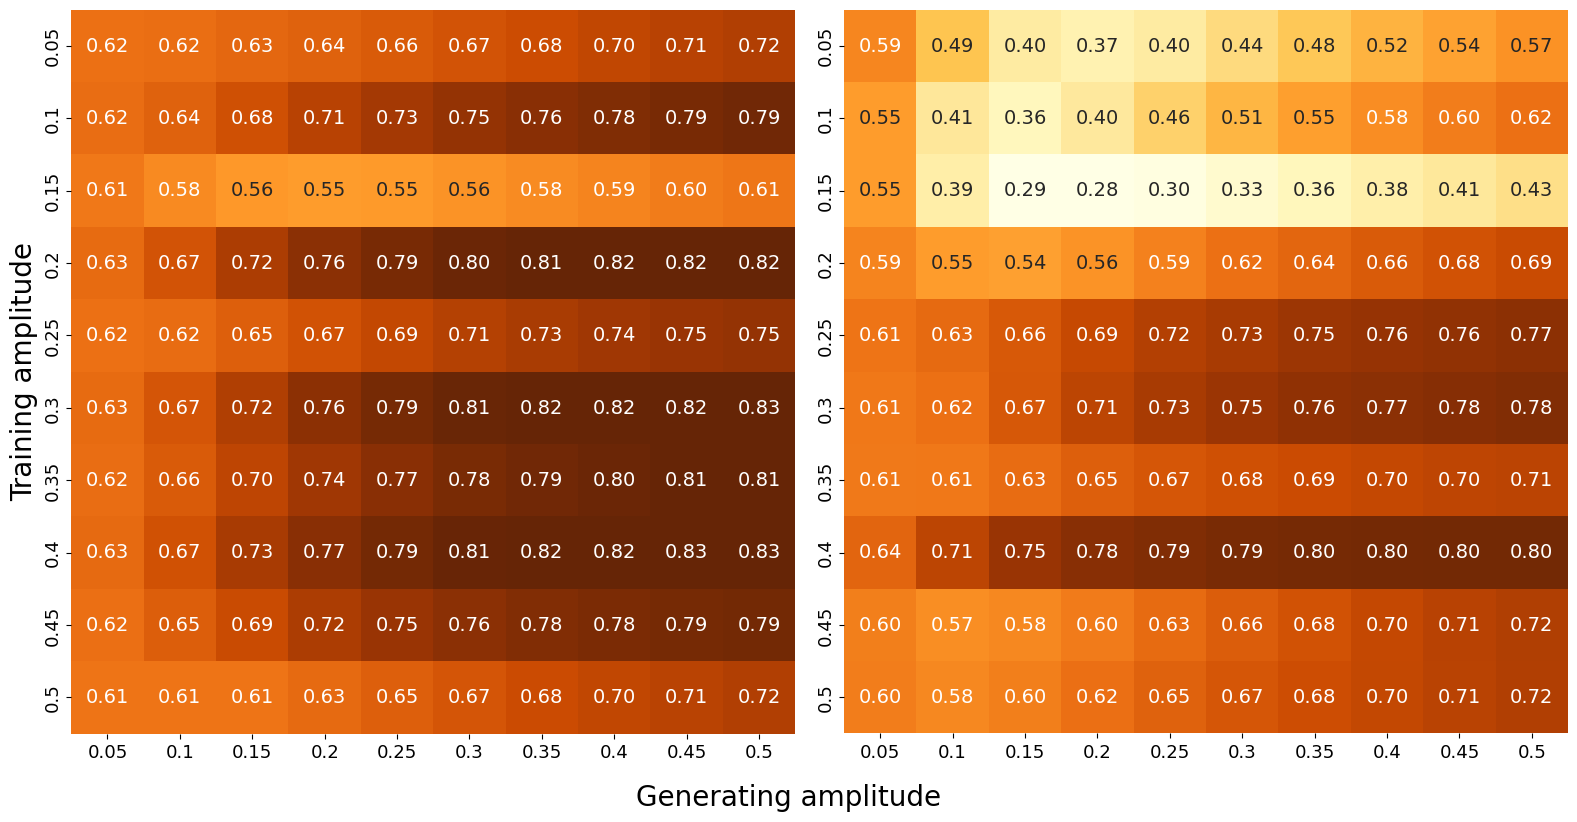

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
fig.tight_layout()
h1=sns.heatmap(ax=ax[0],
               data=df_nospin,
               annot=True,
               fmt=".2f",
               cbar=False,
               square=True,
               #center=0.65,
               vmin=0.3,
               vmax=0.81,
               cmap=sns.color_palette("YlOrBr", as_cmap=True))

h2=sns.heatmap(ax=ax[1],
               data=df_spin,
               annot=True,
               fmt=".2f",
               cbar=False,
               square=True,
               #center=0.65,
               vmin=0.29,
               vmax=0.82,
               cmap=sns.color_palette("YlOrBr", as_cmap=True))


#fig.text(1, 0.5,'Training temperature amplitude', fontsize=20, va='center', rotation=-90)

#ax[0].set_title('Encoding {0,1}', fontsize=20)
ax[0].set_ylabel(r'Training amplitude', fontsize=20)
#ax[0].set_xlabel('Genereting temperature amplitude', fontsize=20)


#ax[1].set_title('Encoding {-1,1}', fontsize=20)
#ax[1].set_ylabel('Training temperature amplitude', fontsize=20, va='center', rotation=-90)
#ax[1].set_xlabel('Genereting temperature amplitude', fontsize=20)
#ax[1].yaxis.set_label_position("right")
#ax[1].yaxis.tick_right()
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=13)

fig.supxlabel('Generating amplitude', fontsize=20,y=0.24)
fig.tight_layout()
plt.plot()

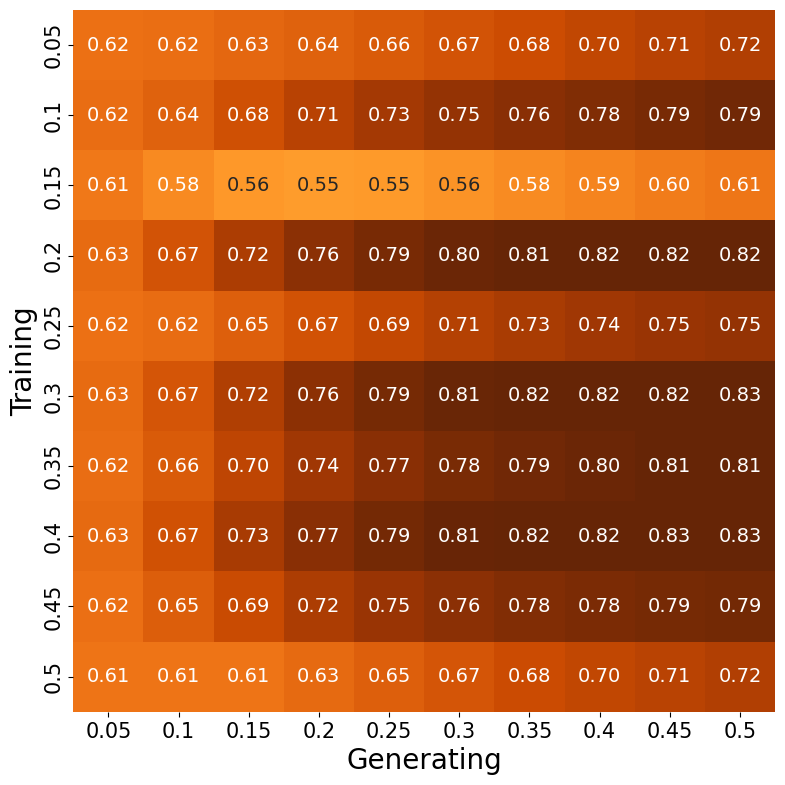

In [9]:
#to save

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
fig.tight_layout()
h1=sns.heatmap(ax=ax,
               data=df_nospin,
               annot=True,
               fmt=".2f",
               cbar=False,
               square=True,
               #center=0.65,
               vmin=0.3,
               vmax=0.81,
               cmap=sns.color_palette("YlOrBr", as_cmap=True))
ax.set_ylabel(r'Training', fontsize=20)
ax.set_xlabel(r'Generating', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('JSheatmaps_nospin.pdf', bbox_inches='tight')

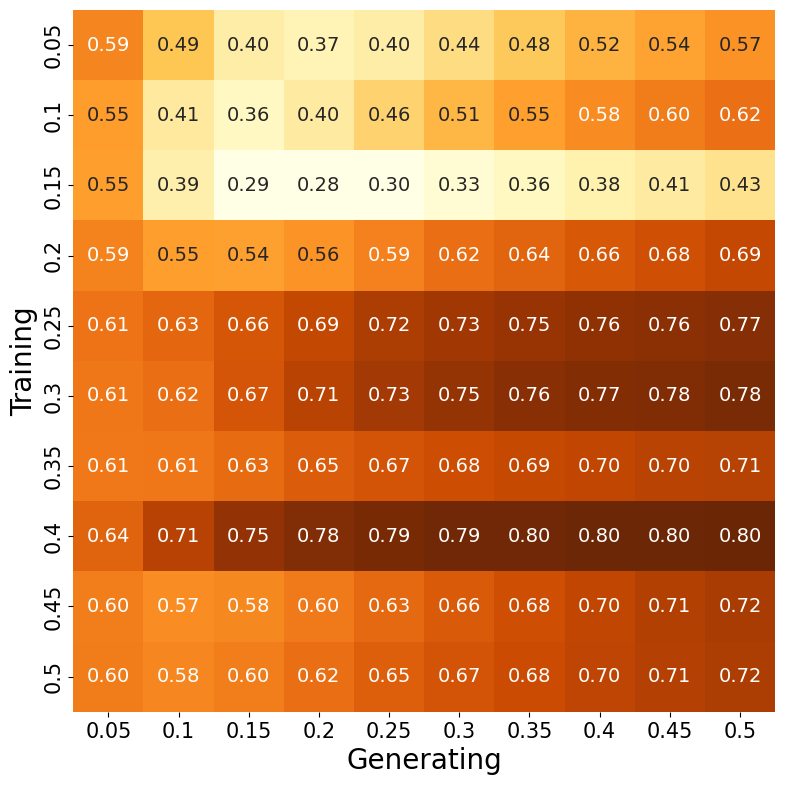

In [10]:
#to save

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
fig.tight_layout()
h1=sns.heatmap(ax=ax,
               data=df_spin,
               annot=True,
               fmt=".2f",
               cbar=False,
               square=True,
               #center=0.65,
               vmin=0.3,
               vmax=0.81,
               cmap=sns.color_palette("YlOrBr", as_cmap=True))
ax.set_ylabel(r'Training', fontsize=20)
ax.set_xlabel(r'Generating', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('JSheatmaps_spin.pdf', bbox_inches='tight' )

# Best model 
As best model we choose the one with the lowest JSD divergens value. We obtain the best result in the {-1,1} representation. Our best model is obtained with training `amp`=0.15.

## Hidden variables' weights
We plot the weights $W_{i\mu}$ of each hidden unit $\mu$ for the best model in an A×G table, with a color map preserving the rule that red means positive and blue means negative weight. A=4 is the number of type of amminoacid allowed in the one-hot encoding. G=5 is number of amminoacid for each protein. 

## Load model and plot the weigths 

In [10]:
file_name='Models/RMSprop_015_1_spin.npz' # the best training so far
amp_best_model = 0.15

rbm = boltzmanmachine(L,M,sigma,vmin=vmin, spin=spin)
rbm.load_model(file_name)
       
w = rbm.w
a = rbm.a
b = rbm.a

n_ammino = 5
n_sub_ammino = 4
n_hidden = M 
L = 20 

## Snapshot of the best model RBM 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


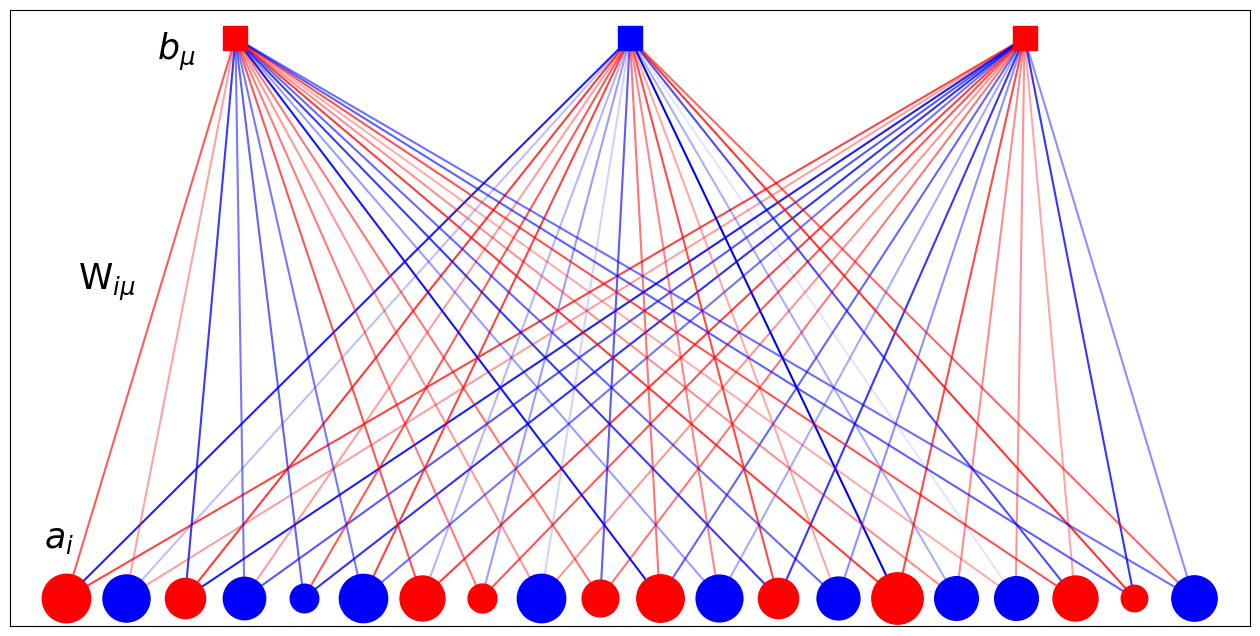

In [107]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(16, 8))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    #ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.42,0.96,r'$b_\mu$', fontsize=25)
    ax.text(-0.49, 0.55, r'W$_{i\mu}$', fontsize=25)
    ax.text(-0.52,0.09,r'$a_i$', fontsize=25)
    plt.savefig('Snapshot_best_model.pdf', bbox_inches='tight')
    plt.show()
                  
plotgraph()

## Best model for {-1,1} representation

In [11]:
ww=w.reshape((n_ammino,n_sub_ammino, n_hidden)) #reshaped: one matrix for each hidden l, one row for each site,

/tmp/ipykernel_7322/1852048356.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[h].set_xticklabels(['']+alpha, fontsize=11)
/tmp/ipykernel_7322/1852048356.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[h].set_yticklabels(['']+alpha, fontsize=13)


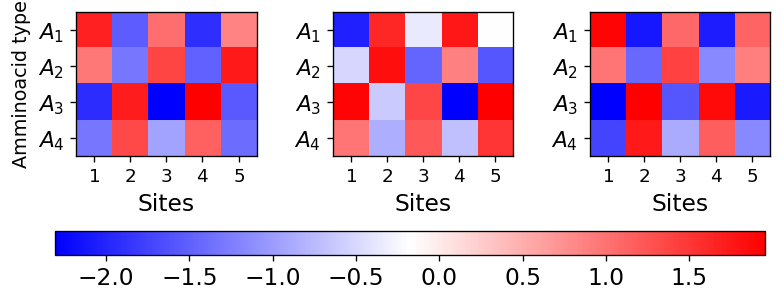

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=n_hidden, figsize=(8,4), dpi=120)
fig.tight_layout()

for h in range(n_hidden):
    c=ax[h].matshow(ww[:,:,h].T, cmap='bwr')
    ax[h].set_xlabel('Sites', fontsize=14)
    alpha = [r'$1$', r'$2$', r'$3$', r'$4$', r'$5$']
    ax[h].set_xticklabels(['']+alpha, fontsize=11)
    if h==0:
        ax[h].set_ylabel('Amminoacid type', fontsize=11.5)
    ax[h].tick_params(top=False, bottom=True,
           labeltop=False, labelbottom=True)
    alpha = [r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$']
    ax[h].set_yticklabels(['']+alpha, fontsize=13)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.055, 0.17, 0.74, 0.05])
fig.colorbar(c, cax=cbar_ax, orientation='horizontal')
plt.savefig('weights_spin.pdf', bbox_inches='tight')
plt.show()

## Best model for {0,1} representation
We provide also the best model for the {0,1} represetation, obtained at `amp`=0.15. Compering this plot and the previus one for the {-1,1} representation we can inferr that the two representations are equally readable. 

In [20]:
file_name_nospin='Models/RMSprop_015_1.npz' # the best training so far
amp_best_model = 0.15

rbm.load_model(file_name_nospin)
       
w = rbm.w
a = rbm.a
b = rbm.a

n_ammino = 5
n_sub_ammino = 4
n_hidden = M 
L = 20 

In [21]:
ww=w.reshape((n_ammino,n_sub_ammino, n_hidden)) #reshaped: one matrix for each hidden l, one row for each site,

/tmp/ipykernel_7322/2869807831.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[h].set_xticklabels(['']+alpha, fontsize=11)
/tmp/ipykernel_7322/2869807831.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[h].set_yticklabels(['']+alpha, fontsize=13)


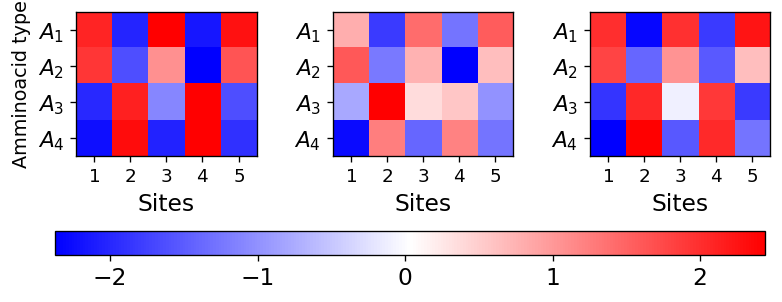

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=n_hidden, figsize=(8,4), dpi=120)
fig.tight_layout()
for h in range(n_hidden):
    c=ax[h].matshow(ww[:,:,h].T, cmap='bwr')
    ax[h].set_xlabel('Sites', fontsize=14)
    alpha = [r'$1$', r'$2$', r'$3$', r'$4$', r'$5$']
    ax[h].set_xticklabels(['']+alpha, fontsize=11)
    if h==0:
        ax[h].set_ylabel('Amminoacid type', fontsize=11.5)
    ax[h].tick_params(top=False, bottom=True,
           labeltop=False, labelbottom=True)
    alpha = [r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$']
    ax[h].set_yticklabels(['']+alpha, fontsize=13)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.055, 0.17, 0.74, 0.05])
fig.colorbar(c, cax=cbar_ax, orientation='horizontal')
plt.savefig('weights_nospin.pdf', bbox_inches='tight')
plt.show()

## Loglikelihood for the best model
The Loglikelihod is plotted as a function of the epochs for every training amplitude for the {-1,1} representaion. As expected, there is a general monotonic increase over the epochs.

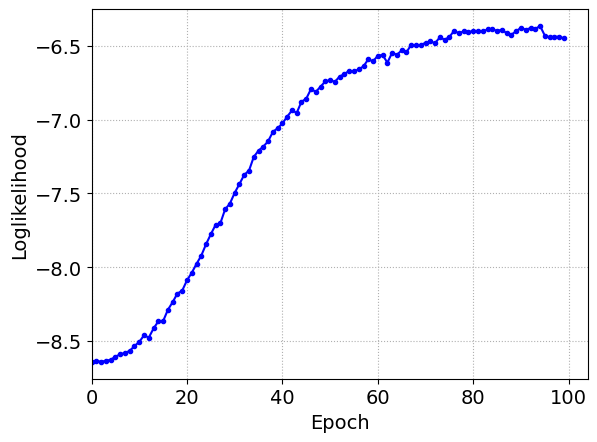

In [102]:
epochs_list = np.arange(n_epochs)
amp_best_model = 0.15

Likelihood_bestmodel = np.load('Models/Loglikelihood/Loglikelihood_'+str(amp_best_model).replace('.','')+'.npz')
plt.plot(epochs_list, Likelihood_bestmodel['Loglikelihood'], '.-', color='b')

plt.xlabel('Epoch')
plt.ylabel('Loglikelihood')
plt.grid(linestyle='dotted')
plt.xlim(0)
plt.savefig('Loglikelihood.pdf', bbox_inches='tight')
plt.show()

## Example of fantasy protein generated by the best model 

In [29]:
#generate the fantasy protein
vf= rbm.gen_fantasy(v0, Amp_gen=0.2)

In [30]:
N_subset=10 #length of the subset considered

#Results are more readable in terms of 0 and 1
if spin:
    vf=((vf)+1)//2
    
#Select the data frame
df=pd.DataFrame.sample(pd.DataFrame(vf), N_subset)
df = df.reset_index(drop=True)
df.columns=['01','02','03', '04', '05', '06', '07', '08', '09',
            '10', '11', '12', '13', '14', '15',
            '16', '17', '18', '19', '20']



#Apply the style to the print
t=[i for i in range(N_subset)]
df.style.apply(
   lambda x: ['background-color: {}'.format("#FFAB06") for i in t], 
   subset=['01','02','03','04', '09','10','11','12', '17','18','19', '20' ]
)\
.hide(axis='index')\
.set_caption('Subset of the generated data, coloured by AAs site')\
.set_properties(**{'font-size': '11pt'})



01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0


# Contrastive Divergence 
We tune the hyperparameter that controls the contrastive divergence algorithm in order to try to improve the best model obtained from the last section.

### Defining CD parameter

In [31]:
cdn  = [2,3]        #set the number of phases
amp_training = 0.2  #amp of the best model
v = v0

### Initialize the Restricted Boltzmann Machine

0.15 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

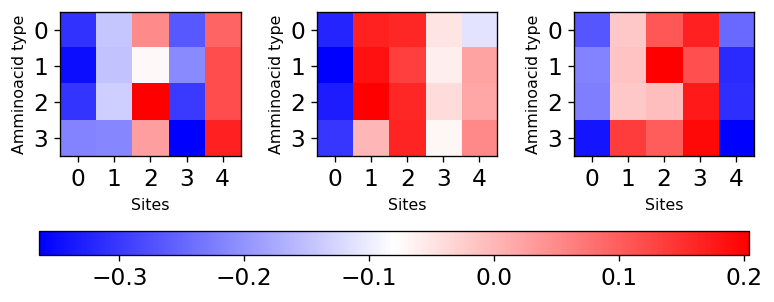

99 	 ...Done!
01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

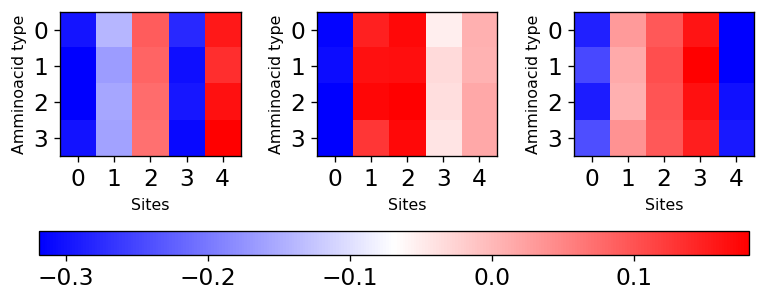

99 	 ...Done!


In [44]:
# random seed for reproducibility
np.random.seed(seed)

# learning rate
l_rate = 1e-3

# minibatch
mini_batch = 500

# train model
print('===================================================')
print(amp_best_model, end=' ')
for cd in cdn:
    for epoch in range(n_epochs):
        # aggregate normalization of batch statistics and learning rate
        for k in range(N):
            rbm.train(data=v[k],
                      learning_rate=l_rate,
                      batch_size=mini_batch,
                      n_contrastive_div=cd,
                      Amp_training=amp_best_model,
                      Algorithm=Algorithm)

        # randomize the order of input data
        np.random.shuffle(v)

        ww = rbm.w.reshape((5,4,M))
        if epoch==n_epochs-1:
            fig, ax = plt.subplots(nrows=1, ncols=M, figsize=(8,4), dpi=120)
            fig.tight_layout()
            for h in range(M):
                c=ax[h].matshow(ww[:,:,h].T, cmap='bwr')
                ax[h].set_xlabel('Sites', fontsize=9.5)
                ax[h].set_ylabel('Amminoacid type', fontsize=9.5)
                ax[h].tick_params(top=False, bottom=True,
                       labeltop=False, labelbottom=True)

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.055, 0.17, 0.74, 0.05])
            fig.colorbar(c, cax=cbar_ax, orientation='horizontal')

            plt.show()
        print(epoch, end='')

    if spin: 
        rbm.save_model('Models/'+str(Algorithm)+'_'+str(amp).replace('.','')+'_'+str(cd)+'_spin'+'.npz')

    print(' \t ...Done!')


### Checking for improvments with contrastive divergence implementation
We evaluate the JS divergence for the two model obtain with CD-2 and CD-3

### CD-2

In [48]:
np.random.seed(seed)
rbm_spin = boltzmanmachine(L,M,sigma, vmin=-1, spin=True)
rbm_spin.load_model('Models/RMSprop_02_2_spin.npz')

vf = rbm_spin.gen_fantasy(v, 0.2)
vf = ((vf+1)/2).astype(int)

proteins_dataset=convert_to_decimal_protein(vf)
p_dataset=return_protein_probabilities(proteins_dataset)
df = pd.DataFrame({'CD-1':[df_spin.iloc[2,3]], 'CD-2':[jensenshannon(p_dataset, Q)]})
pd.options.display.float_format = '{:,.2f}'.format
df

,CD-1,CD-2
0,0.28,0.77


### CD-3

In [49]:
np.random.seed(seed)
rbm_spin = boltzmanmachine(L,M,sigma, vmin=-1, spin=True)
rbm_spin.load_model('Models/RMSprop_02_3_spin.npz')

vf = rbm_spin.gen_fantasy(v, 0.2)
vf = ((vf+1)/2).astype(int)

proteins_dataset=convert_to_decimal_protein(vf)
p_dataset=return_protein_probabilities(proteins_dataset)
df = pd.DataFrame({'CD-1':[df_spin.iloc[2,3]], 'CD-3':[jensenshannon(p_dataset, Q)]})
pd.options.display.float_format = '{:,.2f}'.format
df

,CD-1,CD-3
0,0.28,0.80
